In [1]:
import pickle
import numpy as np
import pandas as pd
import itertools as it
from pathlib import Path
import matplotlib.pylab as plt
from lameg.util import get_files
import nibabel as nib
from scipy.spatial.distance import euclidean
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec

In [2]:
plt.rcParams.update({
    'font.size': 16,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

In [3]:
def add_subplot_label(ax, label, x=-.21, y=1.225):
    ax.text(x, y, label,  # Adjust left of y-axis
            transform=ax.transAxes,
            fontsize=26, va='top', ha='right')


In [4]:
n_layers = 11
layers = np.arange(n_layers)
vx_loc, vx_adj, surf_norm = nib.load(Path("/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/surf/multilayer.11.ds.link_vector.fixed.gii")).agg_data()
layers_loc = np.array(np.split(vx_loc, n_layers, axis=0))
cortical_thickness = np.array([euclidean(layers_loc[0, i, :], layers_loc[-1, i, :]) for i in range(layers_loc.shape[1])])

In [5]:
snr_res = Path("../output/snr_simulations/")
snr_files = get_files(snr_res, "*.pickle")

In [6]:
def annotate_mx(im, txt_mx, **textkw):
    kw = dict(
        horizontalalignment="center",
        verticalalignment="center"
    )
    kw.update(textkw)
    for r, c in it.product(range(txt_mx.shape[0]), range(txt_mx.shape[1])):
        im.axes.text(c, r, txt_mx[r, c], **kw)

def colorbar(mappable, label):
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax, label=label)
    plt.sca(last_axes)
    return cbar


def plot_mx(mx, title="", ax=False, labels=False, cbar=False, cmap="Spectral_r", norm=False, cbar_label=r"$\Delta$ FE"):
    if not ax:
        f, ax = plt.subplots(1, 1)
    else:
        ax = ax
    if not norm:
        iw = ax.imshow(mx, cmap=cmap)
    else:
        iw = ax.imshow(mx, cmap=cmap, norm=norm)
    if labels:
        ax.set_ylabel("Evaluation")
        ax.set_xlabel("Simulation")
        ax.set_xticks([0,n_layers-1])
        ax.set_xticklabels(['S','D'])
        ax.set_yticks([0,n_layers-1])
        ax.set_yticklabels(['S','D'])
        plt.suptitle(title)
        plt.tight_layout()
    if cbar:
        colorbar(iw, cbar_label)
    return iw


def norm_res(mx):
    norm = np.zeros(mx.shape)
    for l in range(mx.shape[1]):
        normed = mx[:,l] - np.min(mx[:,l])
        norm[:,l] = normed
    return norm


def find_peaks(mx, marker="*", return_annot=True):
    annot = np.zeros(mx.shape).astype(np.object_)
    peaks = []
    for l in range(mx.shape[1]):
        peak = np.argmax(mx[:, l]) # here is the problem (you find peak in evaluated!)
        annot[peak,l] = 1.0
        peaks.append(peak)
    peaks = np.array(peaks)
    annot_bin = np.copy(annot).astype(float)
    annot[annot==0.0] = None
    annot[annot==1.0] = marker
    if return_annot:
        return peaks, annot, annot_bin
    else:
        return peaks

def bootstrap_func(data, n_boot=1000, prop=0.5, func="mean"):
    n_rows = data.shape[0]
    rows = np.arange(n_rows)
    prop_rows = int(n_rows*prop)
    results = []
    for b in range(n_boot):
        boot_rows = np.random.choice(rows, size=prop_rows)
        if func == "mean":
            results.append(data[boot_rows].mean(axis=0))
        elif func == "sem":
            results.append(data[boot_rows].std(axis=0) / np.sqrt(prop_rows))
    return np.array(results)


def bootstrap(data, n_boot=1000, prop=0.5):
    n_rows = data.shape[0]
    rows = np.arange(n_rows)
    prop_rows = int(n_rows*prop)
    results = []
    for b in range(n_boot):
        boot_rows = np.random.choice(rows, size=prop_rows)
        results.append(data[boot_rows])
    return np.array(results)


def shuffled_peak_error(mx, ab=False):
    mx_sh = shuffle_mx(mx)
    peaks = find_peaks(mx_sh, return_annot=False)
    peaks = peaks - np.arange(mx.shape[0])
    if not ab:
        return peaks
    else:
        return np.abs(peaks)


def shuffle_mx(mx):
    mx_shape = mx.shape
    mx = mx.flatten()
    np.random.shuffle(mx)
    return mx.reshape(mx_shape)

In [7]:
fnms = np.array([[i] + i.stem.split("_") for i in snr_files])
map_fnms = np.array([i in [1, 3, 5, 6] for i in range(7)])
fnms = fnms[:,~map_fnms]
names_ = ["filename", "vx", "snr"]
df_files = pd.DataFrame.from_dict(
    {k: fnms[:,i] for i, k in enumerate(names_)}
)
df_files["matrix"] = None
df_files.vx = df_files.vx.apply(lambda x: eval(x))
df_files.snr = df_files.snr.apply(lambda x: eval(x))
mxs = []
for ix, row in df_files.iterrows():
    with open(row.filename, "rb") as file:
        output = pickle.load(file)
    output = output["layerF"]
    df_files.at[ix, "matrix"] = output

In [8]:
vertices = df_files.vx.unique()
vertices.sort()
snrs = df_files.snr.unique()
snrs.sort()

In [9]:
matrices_all = {i: [] for i in snrs}
annots_bin = {i: [] for i in snrs}

for vx in vertices:
    for snr_ix, snr in enumerate(snrs):
        row = df_files.loc[
            (df_files.vx == vx) &
            (df_files.snr == snr)
        ]
        mx = row.matrix.values[0]
        mx = norm_res(mx)
        peaks, annot, annot_bin = find_peaks(mx, marker=r"$\wedge$")
        
        matrices_all[snr].append(mx)
        annots_bin[snr].append(annot_bin)

In [10]:
snr_res = Path("../output/snr_simulations/")
snr_files = get_files(snr_res, "*.pickle")
fnms = np.array([[i] + i.stem.split("_") for i in snr_files])
map_fnms = np.array([i in [1, 3, 5, 6] for i in range(7)])
fnms = fnms[:,~map_fnms]
names_ = ["filename", "vx", "snr"]
snr_files = pd.DataFrame.from_dict(
    {k: fnms[:,i] for i, k in enumerate(names_)}
)
snr_files["matrix"] = None
snr_files["norm_matrix"] = None
snr_files["peaks"] = None
snr_files["cortical_thickness"] = None
snr_files["error"] = None
snr_files["bias"] = None
snr_files["sum_error"] = None
snr_files["sum_error_mm"] = None
snr_files["error_mm"] = None
snr_files["bias_mm"] = None
snr_files.vx = snr_files.vx.apply(lambda x: eval(x))
snr_files.snr = snr_files.snr.apply(lambda x: eval(x))
mxs = []
for ix, row in snr_files.iterrows():
    with open(row.filename, "rb") as file:
        output = pickle.load(file)
    output = output["layerF"]
    snr_files.at[ix, "matrix"] = output
    mx = norm_res(output)
    snr_files.at[ix, "norm_matrix"] = mx
    peaks, annot, annot_bin = find_peaks(mx, marker=r"$\wedge$")
    layer_multiplier = cortical_thickness[row.vx] / n_layers
    snr_files.at[ix, "peaks"] = peaks
    snr_files.at[ix, "cortical_thickness"] = cortical_thickness[row.vx]
    snr_files.at[ix, "error"] = np.abs(layers - peaks)
    snr_files.at[ix, "bias"] = layers - peaks
    snr_files.at[ix, "error_mm"] = np.mean(np.abs(layers * layer_multiplier - peaks * layer_multiplier))
    snr_files.at[ix, "bias_mm"] = np.mean(layers * layer_multiplier - peaks * layer_multiplier)
    snr_files.at[ix, "sum_error"] = np.sum(np.abs(layers - peaks))
    snr_files.at[ix, "sum_error_mm"] = np.sum(np.abs(layers * layer_multiplier - peaks * layer_multiplier))

In [11]:
snr_range = snr_files.snr.unique()
snr_range.sort()
snr_files.columns

Index(['filename', 'vx', 'snr', 'matrix', 'norm_matrix', 'peaks',
       'cortical_thickness', 'error', 'bias', 'sum_error', 'sum_error_mm',
       'error_mm', 'bias_mm'],
      dtype='object')

In [12]:
n_permutations = 10000

error_lines = []
bias_lines = []
error_res = []
bias_res = []
shuf_error_res = []
shuf_bias_res = []
p_values_error = []
p_values_bias = []
effect_sizes_error = []
effect_sizes_bias = []

for snr in snr_range:
    matrices = snr_files.loc[snr_files.snr == snr].norm_matrix.values.tolist()
    bias = np.array(snr_files.loc[snr_files.snr == snr].bias.to_list())
    bias = np.mean(bias, axis=-1)
    error = np.array(snr_files.loc[snr_files.snr == snr].error.to_list())
    error = np.mean(error, axis=-1)

    bias_bs = np.mean(bootstrap(bias, n_boot=5000), axis=1)
    error_bs = np.mean(bootstrap(error, n_boot=5000), axis=1)

    permuted_error = np.zeros(n_permutations)
    permuted_bias = np.zeros(n_permutations)
    for idx in range(n_permutations):
        rand_mat=matrices[np.random.randint(len(matrices))]
        permuted_error[idx]=np.mean(shuffled_peak_error(rand_mat,ab=True))
        permuted_bias[idx]=np.mean(shuffled_peak_error(rand_mat,ab=False))
    
    # Compute p-values
    p_value_error = (np.sum(permuted_error < np.mean(error)) + 1) / (n_permutations + 1)
    p_value_bias = (np.sum(np.abs(permuted_bias - np.mean(permuted_bias)) >= np.abs(np.mean(bias) - np.mean(permuted_bias))) + 1) / (n_permutations + 1)
    
    # Compute effect sizes (Cohen's d)
    effect_size_error = (np.mean(error) - np.mean(permuted_error)) / np.std(permuted_error, ddof=1)
    effect_size_bias = (np.mean(bias) - np.mean(permuted_bias)) / np.std(permuted_bias, ddof=1)
    
    # mean 95% CI
    error_95ci = [np.percentile(error_bs, 2.5), np.percentile(error_bs, 97.5)]
    error_95ci_shuf = [np.percentile(permuted_error, 2.5), np.percentile(permuted_error, 97.5)]
    bias_95ci = [np.percentile(bias_bs, 2.5), np.percentile(bias_bs, 97.5)]
    bias_95ci_shuf = [np.percentile(permuted_bias, 2.5), np.percentile(permuted_bias, 97.5)]
    
    error_lines.append(error)
    bias_lines.append(bias)
    error_res.append([np.mean(error)] + error_95ci)
    bias_res.append([np.mean(bias)] + bias_95ci)
    shuf_error_res.append([np.mean(permuted_error)] + error_95ci_shuf)
    shuf_bias_res.append([np.mean(permuted_bias)] + bias_95ci_shuf)
    p_values_error.append(p_value_error)
    p_values_bias.append(p_value_bias)
    effect_sizes_error.append(effect_size_error)
    effect_sizes_bias.append(effect_size_bias)

error_lines = np.array(error_lines)
bias_lines = np.array(bias_lines)
error_res = np.array(error_res)
bias_res = np.array(bias_res)
shuf_error_res = np.array(shuf_error_res)
shuf_bias_res = np.array(shuf_bias_res)
p_values_error = np.array(p_values_error)
p_values_bias = np.array(p_values_bias)
effect_sizes_error = np.array(effect_sizes_error)
effect_sizes_bias = np.array(effect_sizes_bias)

In [13]:
for idx, snr in enumerate(snr_range):
    print(f'{snr} dB, error: d={effect_sizes_error[idx]:.2f}, p={p_values_error[idx]:.3f}; bias: d={effect_sizes_bias[idx]:.2f}, p={p_values_bias[idx]:.3f}')

-500 dB, error: d=1.44, p=0.920; bias: d=-0.01, p=1.000
-100 dB, error: d=1.37, p=0.916; bias: d=-0.05, p=0.960
-50 dB, error: d=-1.72, p=0.047; bias: d=-0.15, p=0.883
-35 dB, error: d=-4.08, p=0.000; bias: d=0.03, p=0.959
-20 dB, error: d=-4.88, p=0.000; bias: d=0.01, p=0.963
-10 dB, error: d=-4.89, p=0.000; bias: d=-0.00, p=1.000
-5 dB, error: d=-4.82, p=0.000; bias: d=0.00, p=1.000
0 dB, error: d=-4.85, p=0.000; bias: d=0.01, p=1.000
5 dB, error: d=-4.90, p=0.000; bias: d=-0.00, p=1.000


In [14]:
error_lines_mm = []
bias_lines_mm = []
error_res_mm = []
bias_res_mm = []
shuf_error_res_mm = []
shuf_bias_res_mm = []
p_values_error_mm = []
p_values_bias_mm = []
effect_sizes_error_mm = []
effect_sizes_bias_mm = []

for snr in snr_range:
    layer_mpl = snr_files.loc[snr_files.snr == snr].cortical_thickness.to_numpy() / 11
    matrices = snr_files.loc[snr_files.snr == snr].norm_matrix.values.tolist()
    bias = np.array(snr_files.loc[snr_files.snr == snr].bias.to_list())
    bias = np.mean(bias, axis=-1) * layer_mpl
    error = np.array(snr_files.loc[snr_files.snr == snr].error.to_list())
    error = np.mean(error, axis=-1) * layer_mpl

    bias_bs = np.mean(bootstrap(bias, n_boot=5000), axis=1)
    error_bs = np.mean(bootstrap(error, n_boot=5000), axis=1)

    permuted_error = np.zeros(n_permutations)
    permuted_bias = np.zeros(n_permutations)
    for idx in range(n_permutations):
        v_idx=np.random.randint(len(matrices))
        rand_mat=matrices[v_idx]
        permuted_error[idx] = np.mean(shuffled_peak_error(rand_mat, ab=True) * layer_mpl[v_idx])        
        permuted_bias[idx] = np.mean(shuffled_peak_error(rand_mat, ab=False) * layer_mpl[v_idx])
    
    # Compute p-values
    p_value_error_mm = (np.sum(permuted_error < np.mean(error)) + 1) / (n_permutations + 1)
    p_value_bias_mm = (np.sum(np.abs(permuted_bias - np.mean(permuted_bias)) >= np.abs(np.mean(bias) - np.mean(permuted_bias))) + 1) / (n_permutations + 1)
    
    # Compute effect sizes (Cohen's d)
    effect_size_error_mm = (np.mean(error) - np.mean(permuted_error)) / np.std(permuted_error, ddof=1)
    effect_size_bias_mm = (np.mean(bias) - np.mean(permuted_bias)) / np.std(permuted_bias, ddof=1)
    
    # mean 95% CI
    error_95ci = [np.percentile(error_bs, 2.5), np.percentile(error_bs, 97.5)]
    error_95ci_shuf = [np.percentile(permuted_error, 2.5), np.percentile(permuted_error, 97.5)]
    bias_95ci = [np.percentile(bias_bs, 2.5), np.percentile(bias_bs, 97.5)]
    bias_95ci_shuf = [np.percentile(permuted_bias, 2.5), np.percentile(permuted_bias, 97.5)]
    
    error_lines_mm.append(error)
    bias_lines_mm.append(bias)
    error_res_mm.append([np.mean(error)] + error_95ci)
    bias_res_mm.append([np.mean(bias)] + bias_95ci)
    shuf_error_res_mm.append([np.mean(permuted_error)] + error_95ci_shuf)
    shuf_bias_res_mm.append([np.mean(permuted_bias)] + bias_95ci_shuf)
    p_values_error_mm.append(p_value_error_mm)
    p_values_bias_mm.append(p_value_bias_mm)
    effect_sizes_error_mm.append(effect_size_error_mm)
    effect_sizes_bias_mm.append(effect_size_bias_mm)

error_lines_mm = np.array(error_lines_mm)
bias_lines_mm = np.array(bias_lines_mm)
error_res_mm = np.array(error_res_mm)
bias_res_mm = np.array(bias_res_mm)
shuf_error_res_mm = np.array(shuf_error_res_mm)
shuf_bias_res_mm = np.array(shuf_bias_res_mm)
p_values_error_mm = np.array(p_values_error_mm)
p_values_bias_mm = np.array(p_values_bias_mm)
effect_sizes_error_mm = np.array(effect_sizes_error_mm)
effect_sizes_bias_mm = np.array(effect_sizes_bias_mm)

In [15]:
for idx, snr in enumerate(snr_range):
    print(f'{snr} dB, error: d={effect_sizes_error_mm[idx]:.2f}, p={p_values_error_mm[idx]:.3f}; bias: d={effect_sizes_bias_mm[idx]:.2f}, p={p_values_bias_mm[idx]:.3f}')

-500 dB, error: d=0.83, p=0.796; bias: d=-0.06, p=0.961
-100 dB, error: d=0.81, p=0.790; bias: d=-0.08, p=0.940
-50 dB, error: d=-1.04, p=0.147; bias: d=-0.15, p=0.866
-35 dB, error: d=-2.43, p=0.000; bias: d=0.02, p=0.961
-20 dB, error: d=-2.81, p=0.000; bias: d=0.02, p=0.961
-10 dB, error: d=-2.81, p=0.000; bias: d=-0.01, p=0.985
-5 dB, error: d=-2.86, p=0.000; bias: d=0.01, p=0.988
0 dB, error: d=-2.86, p=0.000; bias: d=-0.00, p=0.986
5 dB, error: d=-2.82, p=0.000; bias: d=0.00, p=0.986


In [16]:
tick_labels = [f"{i}" for i in snr_range]
tick_labels[0] = r"-$\infty$"
snr_ix = np.arange(snr_range.shape[0])
snr_ix[0] = snr_ix[0] - 1

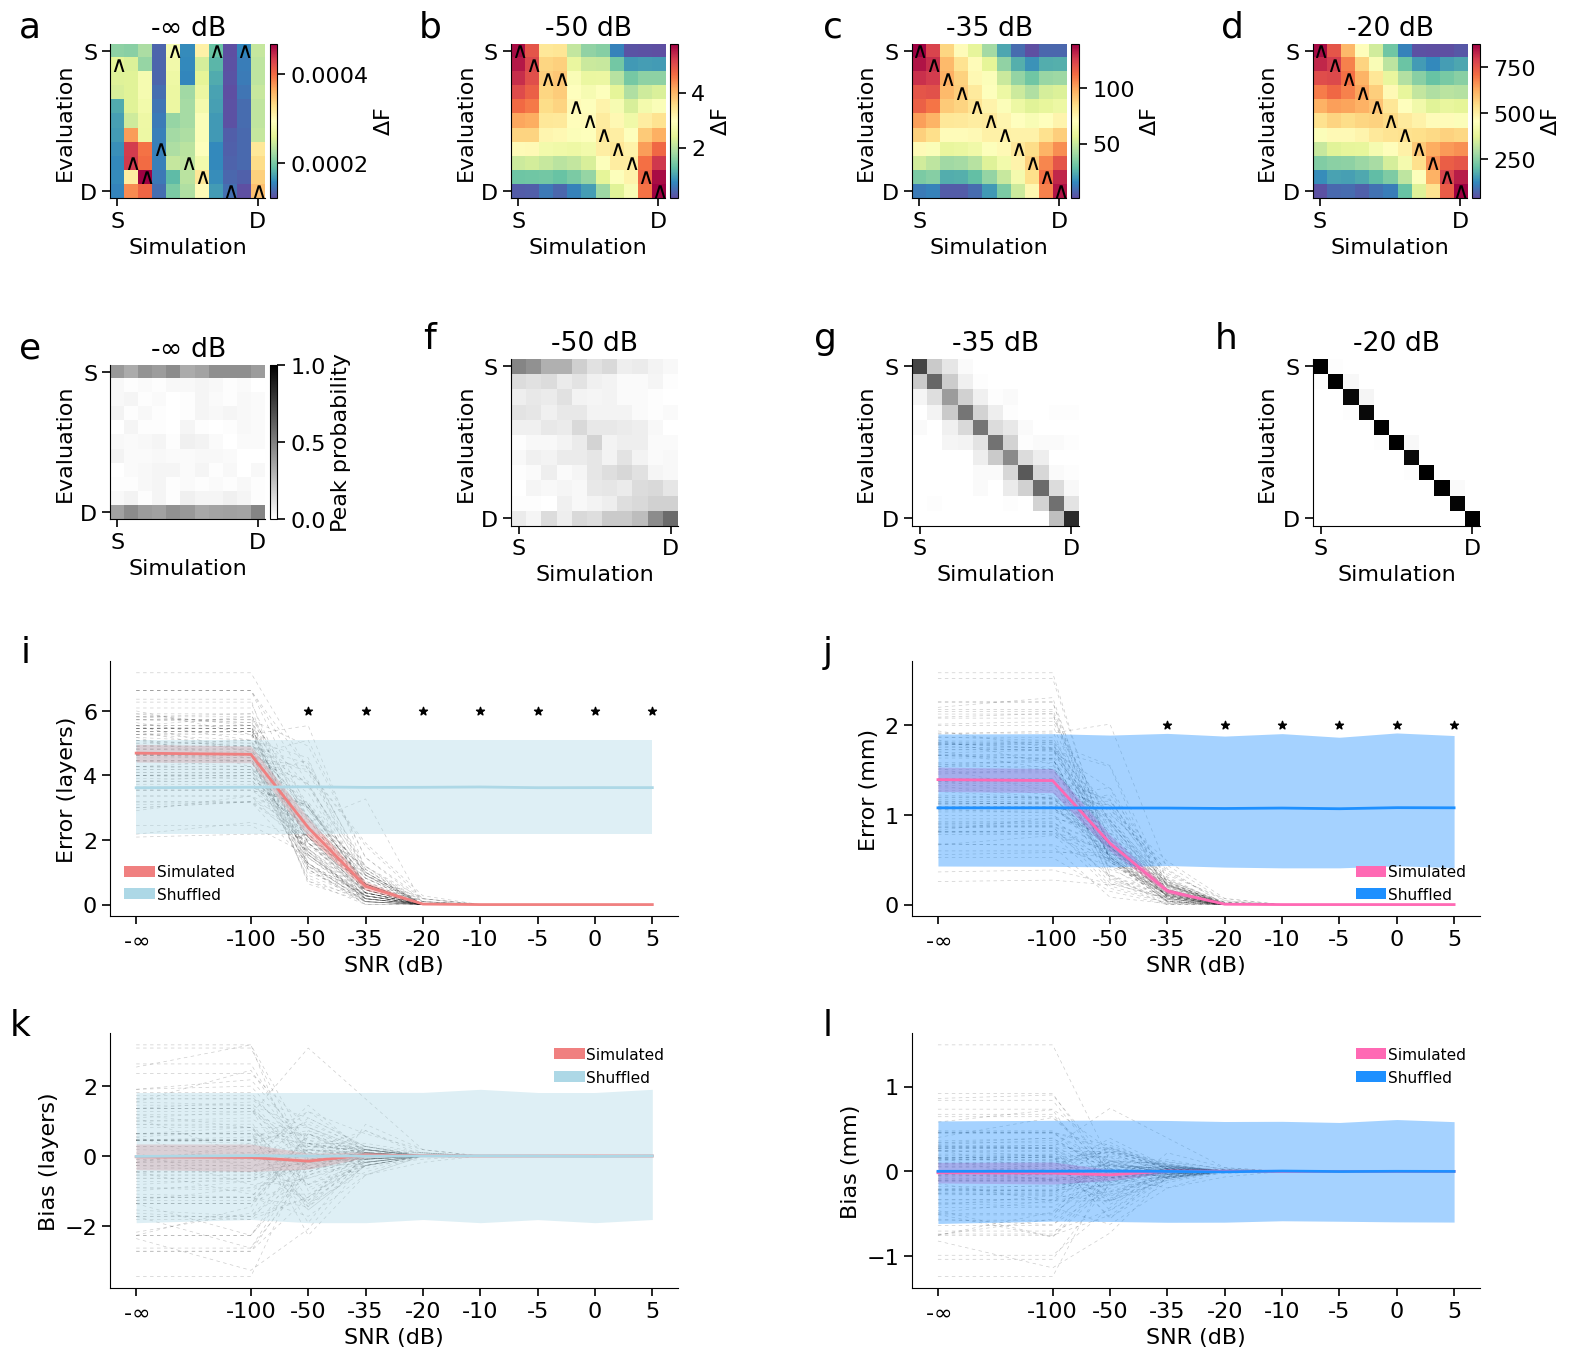

In [17]:
snrs_to_plot=[-500, -50, -35, -20]
fig=plt.figure(figsize=(4*len(snrs_to_plot), 14), facecolor="white")
gs = GridSpec(4, len(snrs_to_plot), height_ratios=[1, 1, 1.25, 1.25])
labels=['a','b','c','d']
for snr_idx, snr in enumerate(snrs_to_plot):
    ax = fig.add_subplot(gs[0,snr_idx])
    if snr_idx == 0:
        ax.set_title(r"-$\infty$ dB")
    else:
        ax.set_title(f"{snr} dB")
    m_mx = np.mean(matrices_all[snr], axis=0)
    peaks, annot, annot_bin = find_peaks(m_mx, marker=r"$\wedge$")
    iw = plot_mx(m_mx, ax=ax, labels=True, cbar=True, cbar_label=r"$\Delta$F")
    annotate_mx(iw, annot)
    add_subplot_label(ax, labels[snr_idx], x=-.45)

labels=['e','f','g','h']
divnorm = Normalize(vmin=0, vmax=1)
for snr_idx, snr in enumerate(snrs_to_plot):
    ax = fig.add_subplot(gs[1,snr_idx])
    m_mx = np.mean(annots_bin[snr], axis=0)
    if snr_idx == 0:
        iw = plot_mx(m_mx, ax=ax, labels=True, cmap="binary", norm=divnorm, cbar=True, cbar_label=r"Peak probability")
        ax.set_title(r"-$\infty$ dB")
    else:
        ax.set_title(f"{snr} dB")
        iw = plot_mx(m_mx, ax=ax, labels=True, cmap="binary", norm=divnorm)
    add_subplot_label(ax, labels[snr_idx], x=-.45)
        
        
ax=fig.add_subplot(gs[2,0:2])
legend_handles = [
    Patch(facecolor="lightcoral", linewidth=0, label="Simulated"),
    Patch(facecolor="lightblue", linewidth=0, label="Shuffled")
]
clrs = ["lightcoral", "lightblue"]
labs = ["simulated data", "shuffled data"]
for rix, r in enumerate([error_res, shuf_error_res]):
    ax.plot(snr_ix, r[:,0], color=clrs[rix], lw=2)
    ax.fill_between(snr_ix, r[:,1], r[:,2], color=clrs[rix], lw=0, alpha=0.4)
ax.set_xticks(snr_ix)
ax.set_xticklabels(tick_labels)
ax.set_ylabel("Error (layers)")
ax.set_xlabel("SNR (dB)")
ax.legend(handles=legend_handles, fontsize="x-small", loc='lower left')
ax.plot(snr_ix, error_lines, lw=0.5, c="black", alpha=0.2, linestyle='--', dashes=(5, 5), zorder=0)
sig_levels=np.where(p_values_error<0.05)[0]
ax.scatter(snr_ix[sig_levels],np.tile(6,len(sig_levels)),marker='*',color='k')
add_subplot_label(ax, 'i', x=-.14, y=1.1)


ax=fig.add_subplot(gs[2,2:4])
legend_handles = [
    Patch(facecolor="hotpink", linewidth=0, label="Simulated"),
    Patch(facecolor="dodgerblue", linewidth=0, label="Shuffled")
]
clrs = ["hotpink", "dodgerblue"]
labs = ["simulated data", "shuffled data"]
for rix, r in enumerate([error_res_mm, shuf_error_res_mm]):
    ax.plot(snr_ix, r[:,0], color=clrs[rix], lw=2)
    ax.fill_between(snr_ix, r[:,1], r[:,2], color=clrs[rix], lw=0, alpha=0.4)
ax.set_xticks(snr_ix)
ax.set_xticklabels(tick_labels)
ax.set_ylabel("Error (mm)")
ax.set_xlabel("SNR (dB)")
ax.legend(handles=legend_handles, fontsize="x-small", loc='lower right')
ax.plot(snr_ix, error_lines_mm, lw=0.5, c="black", alpha=0.2, linestyle='--', dashes=(5, 5), zorder=0)
sig_levels=np.where(p_values_error_mm<0.05)[0]
ax.scatter(snr_ix[sig_levels],np.tile(2,len(sig_levels)),marker='*',color='k')
add_subplot_label(ax, 'j', x=-.14, y=1.1)


ax=fig.add_subplot(gs[3,0:2])
legend_handles = [
    Patch(facecolor="lightcoral", linewidth=0, label="Simulated"),
    Patch(facecolor="lightblue", linewidth=0, label="Shuffled")
]
clrs = ["lightcoral", "lightblue"]
labs = ["simulated data", "shuffled data"]
for rix, r in enumerate([bias_res, shuf_bias_res]):
    ax.plot(snr_ix, r[:,0], color=clrs[rix], lw=2)
    ax.fill_between(snr_ix, r[:,1], r[:,2], color=clrs[rix], lw=0, alpha=0.4)
ax.set_xticks(snr_ix)
ax.set_xticklabels(tick_labels)
ax.set_ylabel("Bias (layers)")
ax.set_xlabel("SNR (dB)")
ax.legend(handles=legend_handles, fontsize="x-small", loc=1)
ax.plot(snr_ix, bias_lines, lw=0.5, c="black", alpha=0.2, linestyle='--', dashes=(5, 5), zorder=0)
sig_levels=np.where(p_values_bias<0.05)[0]
ax.scatter(snr_ix[sig_levels],np.tile(2,len(sig_levels)),marker='*',color='k')
add_subplot_label(ax, 'k', x=-.14, y=1.1)


ax=fig.add_subplot(gs[3,2:4])
legend_handles = [
    Patch(facecolor="hotpink", linewidth=0, label="Simulated"),
    Patch(facecolor="dodgerblue", linewidth=0, label="Shuffled")
]
clrs = ["hotpink", "dodgerblue"]
labs = ["simulated data", "shuffled data"]
for rix, r in enumerate([bias_res_mm, shuf_bias_res_mm]):
    ax.plot(snr_ix, r[:,0], color=clrs[rix], lw=2)
    ax.fill_between(snr_ix, r[:,1], r[:,2], color=clrs[rix], lw=0, alpha=0.4)
ax.set_xticks(snr_ix)
ax.set_xticklabels(tick_labels)
ax.set_ylabel("Bias (mm)")
ax.set_xlabel("SNR (dB)")
ax.legend(handles=legend_handles, fontsize="x-small", loc=1)
ax.plot(snr_ix, bias_lines_mm, lw=0.5, c="black", alpha=0.2, linestyle='--', dashes=(5, 5), zorder=0)
sig_levels=np.where(p_values_bias_mm<0.05)[0]
ax.scatter(snr_ix[sig_levels],np.tile(1,len(sig_levels)),marker='*',color='k')
add_subplot_label(ax, 'l', x=-.14, y=1.1)

plt.tight_layout()
plt.savefig(f"figure_02_snr.pdf")

In [18]:
snr_range

array([-500, -100,  -50,  -35,  -20,  -10,   -5,    0,    5])

In [19]:
def diagonal_dominance_score(matrix):
    return np.trace(matrix) / np.sum(matrix)

dds = np.zeros(len(snr_range))
permuted_dds = np.zeros((len(snr_range), n_permutations))
p_vals_dds = np.zeros(len(snr_range))
effect_sizes_dds = np.zeros(len(snr_range))
for s_idx, snr in enumerate(snr_range):
    matrices = np.array(snr_files.loc[snr_files.snr == snr].norm_matrix.values.tolist())
    mat=np.mean(matrices,axis=0)
    dds[s_idx]=diagonal_dominance_score(mat)

    for idx in range(n_permutations):
        permuted_dds[s_idx,idx] = diagonal_dominance_score(shuffle_mx(mat))
        
    p_value_dds = (np.sum(np.abs(permuted_dds[s_idx,:] - np.mean(permuted_dds[s_idx,:])) >= np.abs(dds[s_idx] - np.mean(permuted_dds[s_idx,:]))) + 1) / (n_permutations + 1)
    p_vals_dds[s_idx]=p_value_dds
    effect_sizes_dds[s_idx] = (dds[s_idx] - np.mean(permuted_dds[s_idx,:])) / np.std(permuted_dds[s_idx,:], ddof=1)
    print(f'{snr} dB, d={effect_sizes_dds[s_idx]:.2f}, p={p_vals_dds[s_idx]:.3f}')
dds_95ci_shuf = [np.percentile(permuted_dds, 2.5), np.percentile(permuted_dds, 97.5)]

-500 dB, d=0.13, p=0.899
-100 dB, d=0.83, p=0.416
-50 dB, d=3.25, p=0.001
-35 dB, d=3.59, p=0.000
-20 dB, d=4.09, p=0.000
-10 dB, d=4.08, p=0.000
-5 dB, d=4.08, p=0.000
0 dB, d=4.08, p=0.000
5 dB, d=4.06, p=0.000


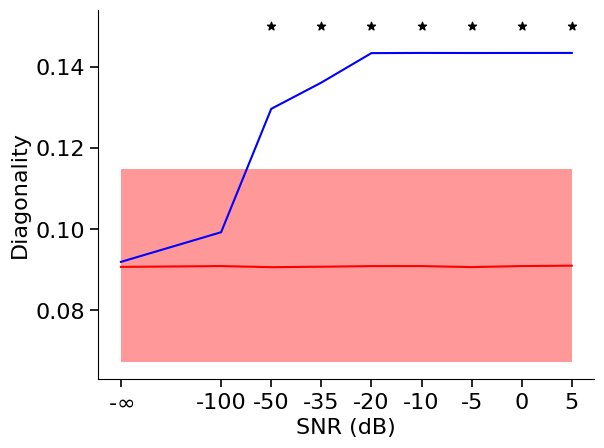

In [23]:
sig_levels=np.where(p_vals_dds<0.05)[0]
plt.figure()
ax=plt.subplot(1,1,1)
ax.plot(snr_ix,dds,'b')
ax.plot(snr_ix,np.mean(permuted_dds,axis=-1),'r')
ax.fill_between(snr_ix, dds_95ci_shuf[0], dds_95ci_shuf[1], color='r', lw=0, alpha=0.4)
ax.scatter(snr_ix[sig_levels],np.tile(.15,len(sig_levels)),marker='*',color='k')
ax.set_xticks(snr_ix)
_=ax.set_xticklabels(tick_labels)
ax.set_xlabel('SNR (dB)')
ax.set_ylabel('Diagonality')
plt.savefig(f"figure_SX_snr_diagonality.pdf")

In [21]:
all_layer_err=np.zeros((len(snr_range),100,11))
all_layer_bias=np.zeros((len(snr_range),100,11))
for s_idx, snr in enumerate(snr_range):
    error = np.array(snr_files.loc[snr_files.snr == snr].error.to_list())
    bias = np.array(snr_files.loc[snr_files.snr == snr].bias.to_list())
    all_layer_err[s_idx,:,:]=error
    all_layer_bias[s_idx,:,:]=bias

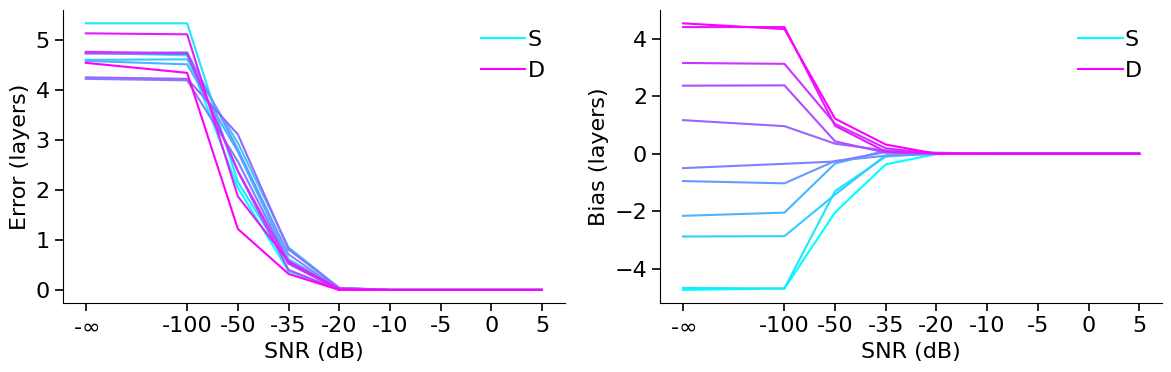

In [22]:
col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(12,4))
ax=plt.subplot(1,2,1)
for i in range(n_layers):
    label=None
    if i==0:
        label='S'
    elif i==n_layers-1:
        label='D'
    plt.plot(snr_ix, np.mean(all_layer_err[:,:,i],axis=1), color=col_r[i,:], label=label)
ax.legend()
ax.set_xticks(snr_ix)
_=ax.set_xticklabels(tick_labels)
ax.set_ylabel('Error (layers)')
ax.set_xlabel('SNR (dB)')

ax=plt.subplot(1,2,2)
for i in range(n_layers):
    label=None
    if i==0:
        label='S'
    elif i==n_layers-1:
        label='D'
    plt.plot(snr_ix, np.mean(all_layer_bias[:,:,i],axis=1), color=col_r[i,:], label=label)
ax.legend()
ax.set_xticks(snr_ix)
_=ax.set_xticklabels(tick_labels)
ax.set_ylabel('Bias (layers)')
ax.set_xlabel('SNR (dB)')
plt.tight_layout()
plt.savefig(f"figure_SX_snr_layers.pdf")